In [10]:
import pandas as pd
from prophet import Prophet

In [11]:
# Load data
data_path = "data_NO2.csv"
df = pd.read_csv(data_path, delimiter=';')

df_orig = df.copy()

# Convert to datetime and remove timezone
df['datetime_utc'] = pd.to_datetime(df['datetime_utc']).dt.tz_localize(None)

# Keep the test data
df_test = df.copy()
df_test = df_test.iloc[-5000:]

# Remove last rows of data
df = df.iloc[:-5000]

# Drop unwanted columns
df = df[['datetime_utc', 'volume_demand', 'spot_price']]

# Rename columns
df = df.rename(columns={'spot_price': 'y', 'datetime_utc': 'ds'})


# Display the updated DataFrame
df.head()


,ds,volume_demand,y
0,2015-12-31 23:00:00,4043.0,16.39
1,2016-01-01 00:00:00,4010.0,16.04
2,2016-01-01 01:00:00,3930.0,15.74
3,2016-01-01 02:00:00,3839.0,15.57
4,2016-01-01 03:00:00,3833.0,15.47


In [12]:
m = Prophet()
# Add extra regressors
m.add_regressor('volume_demand')
m.fit(df)

14:14:18 - cmdstanpy - INFO - Chain [1] start processing
14:14:29 - cmdstanpy - INFO - Chain [1] done processing


In [13]:
future = m.make_future_dataframe(periods=5000, freq='H')
future['volume_demand'] = df_orig['volume_demand'].values
future.shape


/Users/johanbjerkem/Library/CloudStorage/OneDrive-NTNU/Documents/NTNU/5klassehost/ads/TDT4259/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(


(23666, 2)

In [14]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
23661,2018-09-12 22:00:00,42.893798,-3.528531,90.236575
23662,2018-09-12 23:00:00,42.268506,-4.191003,89.715983
23663,2018-09-13 00:00:00,41.819634,-5.146613,89.840701
23664,2018-09-13 01:00:00,42.079593,-4.866684,89.311817
23665,2018-09-13 02:00:00,42.420887,-3.306563,90.164010


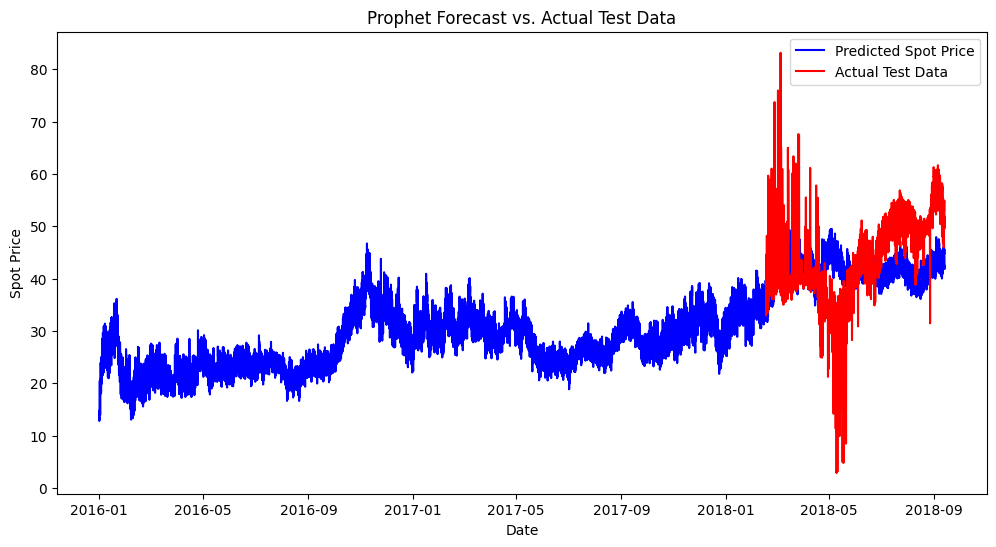

In [15]:
import matplotlib.pyplot as plt

# Plot the forecasted values
plt.figure(figsize=(12, 6))
plt.plot(forecast['ds'], forecast['yhat'], color='blue', label='Predicted Spot Price')

# Plot the actual test data
plt.plot(df_test['datetime_utc'], df_test['spot_price'], color='red', label='Actual Test Data')

# Add labels and legend
plt.xlabel('Date')
plt.ylabel('Spot Price')
plt.title("Prophet Forecast vs. Actual Test Data")
plt.legend()
plt.show()


In [16]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Extract the forecasted values for the test period
forecast_test = forecast.iloc[-len(df_test):]  # Select the last part of the forecast that matches the test period

# Calculate MSE and RMSE
mse = mean_squared_error(df_test['spot_price'], forecast_test['yhat'])
rmse = np.sqrt(mse)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")


Mean Squared Error (MSE): 78.14535301220003
Root Mean Squared Error (RMSE): 8.839986030090774
